In [71]:
from augur.utils import json_to_tree
from Bio import SeqIO
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D 
from scipy import stats

### Plot the nonsyn evolutionary rate vs. mean Pearson r for correlation between growth rate and muts

In [2]:
all_genes = ['Nsp1', 'Nsp2', 'Nsp3', 'Nsp4', 'Nsp5', 'Nsp6', 'Nsp7', 'Nsp8', 
             'Nsp9', 'Nsp10', 'Nsp12', 'Nsp13', 'Nsp14', 'Nsp15', 'Nsp16', 
             'S', 'S1', 'S2', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 
             'ORF7b', 'ORF8', 'N', 'ORF9b', 'ORF10']

In [4]:
def readin_tree(date, tree_type):
    """
    Read in the 2m tree json for the specified date
    """

    # path to tree json
    if tree_type == 'sars2':
        tree_file = f'trees_w_mut_counts/sars2_{date}_2m.json'
    elif tree_type == '21L':
        tree_file = f'trees_w_mut_counts/sars2_21L_{date}_2m.json'    

    with open(tree_file, 'r') as f:
        tree_json = json.load(f)

    # put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    return tree

In [3]:
def get_mut_and_growth_info(date, tree_type):
    """
    Get logistic growth and number of mutations for each node in the tree
    """
    tree = readin_tree(date, tree_type)
    
    mut_and_growth_info = []
    
    
    for node in tree.find_clades():
        # only for nodes that have an assigned logistic growht rate (those that are in the past 6 weeks)
        if 'logistic_growth' in node.node_attrs:
            logistic_growth = node.node_attrs['logistic_growth']['value']
            # look at mutations in each gene
            for gene in all_genes:
                nonsyn_muts = node.mut_accumulation['Nonsyn_muts'][gene]
                syn_muts = node.mut_accumulation['Syn_muts'][gene]
                stop_muts = node.mut_accumulation['Stop_muts'][gene]
                
                mut_and_growth_info.append({'date': date, 'gene':gene, 'node': node.name,
                                            'logistic_growth': logistic_growth, 
                                            'nonsyn': nonsyn_muts, 'syn': syn_muts, 'stop': stop_muts})
                
    df = pd.DataFrame(mut_and_growth_info)
    
    return df

In [13]:
def get_correlations(date, df):
    """
    Get correlation coefficient r for mutations in each gene vs logisitic growth rate
    Do this for each type of mutation
    """
    
    pearsons_r = []
    
    for gene in all_genes:
        df_gene = df[df['gene']==gene]
        x_n = df_gene['nonsyn'].to_numpy()
        x_s = df_gene['syn'].to_numpy()
        x_stop = df_gene['stop'].to_numpy()
        y = df_gene['logistic_growth'].to_numpy()
        # get the Pearson's r. scipy return (r, p-value)
        r_nonsyn = stats.pearsonr(x_n, y)[0]
        r_syn = stats.pearsonr(x_s, y)[0]
        # gets angry about having all 0's
#         r_stop = scipy.stats.pearsonr(x_stop, y)[0]
        pearsons_r.append({'date': date, 'gene': gene, 'r_nonsyn': r_nonsyn, 'r_syn': r_syn})

    pearsons_df = pd.DataFrame(pearsons_r)
    return pearsons_df

In [14]:
# run all dates, so they're saved in memory
all_dates = ['2020-03', '2020-05', '2020-07', '2020-09', '2020-11', 
             '2021-01', '2021-03', '2021-05', '2021-07', '2021-09', '2021-11', 
             '2022-01', '2022-03', '2022-05', '2022-07', '2022-09', '2022-11', 
             '2023-01', '2023-03', '2023-05']
pearsons_df_sars2 = pd.DataFrame()

for date in all_dates:
    df_date = get_mut_and_growth_info(date, 'sars2')

    pearsons_df_date = get_correlations(date, df_date)
    pearsons_df_sars2 = pd.concat([pearsons_df_sars2, pearsons_df_date])

/Users/katekistler/opt/miniconda3/envs/nextstrain/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [23]:
# get the mean r_nonsyn over all time points

mean_r = pearsons_df_sars2.groupby('gene')['r_nonsyn'].mean().reset_index()

In [15]:
# Use the pandemic-long tree with even sampling over time to get 
# the rates of nonsynonymous mutations for each gene

alltime_tree_file = f'trees_w_mut_counts/sars2_alltime_2023-06.json'    

with open(alltime_tree_file, 'r') as f:
    tree_json = json.load(f)

# put tree in Bio.phylo format
alltime_tree = json_to_tree(tree_json)

# store the date and number of nonsyn muts for each node
dates_and_muts_by_gene = {g:{'date':[], 'nonsyn_muts':[]} for g in all_genes}

for node in alltime_tree.find_clades():
    date = node.node_attrs['num_date']['value']
    for gene in all_genes:
        nonsyn_muts = node.mut_accumulation['Nonsyn_muts'][gene]
        dates_and_muts_by_gene[gene]['date'].append(date)
        dates_and_muts_by_gene[gene]['nonsyn_muts'].append(nonsyn_muts)

# store rate info
rate_by_gene = {}

# for each gene, use linear regression slope to get rate of nonsyn evo
for g, n in dates_and_muts_by_gene.items():
    x = n['date']
    y= n['nonsyn_muts']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    rate_by_gene[g] = slope


In [31]:
# normalize each rate by the length of the gene, in codons

# store gene length info
length_of_gene = {}

with open("reference_all_genes.gb") as reference_handle:
    for record in SeqIO.parse(reference_handle, "genbank"):
        wuhan_seq = record.seq
        for feature in record.features:
            if feature.type == 'CDS':
                gene = feature.qualifiers['gene'][0]
                length = len(feature.location.extract(wuhan_seq))/3
                length_of_gene[gene] = length
                
# divide each rate of nonsynonymous mutations per year by the number of codons in gene
normalized_rate_by_gene = {g:v/length_of_gene[g] for g,v in rate_by_gene.items()}

In [43]:
# from Brendan Artley (https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b)
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [147]:
# make a bunch of related colors for each type of gene
cmap = {}
edge_cmap = {}

# nonstructural is red 
nonstructural_genes = ['Nsp1', 'Nsp2', 'Nsp3', 'Nsp4', 'Nsp5', 'Nsp6', 'Nsp7', 'Nsp8', 
                       'Nsp9', 'Nsp10', 'Nsp12', 'Nsp13', 'Nsp14', 'Nsp15', 'Nsp16']
# nonstructural_colors = get_color_gradient('#701e30', '#f8e6e5', len(nonstructural_genes))
# nonstructural_edges = get_color_gradient('#330e16', '#f3d3d1', len(nonstructural_genes))
nonstructural_colors = get_color_gradient('#9F2A44', '#f8e6e5', len(nonstructural_genes))
nonstructural_edges = get_color_gradient('#621a2a', '#f3d3d1', len(nonstructural_genes))
for i in range(len(nonstructural_genes)):
    g = nonstructural_genes[i]
    cmap[g] = nonstructural_colors[i]
    edge_cmap[g] = nonstructural_edges[i]
    
# accessory is yellow
accessory_genes = ['ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'ORF9b', 'ORF10']
accessory_colors = get_color_gradient('#ed8a0e', '#f9df9a', len(accessory_genes))
accessory_edges = get_color_gradient('#bb410a', '#f4a137', len(accessory_genes))
for i in range(len(accessory_genes)):
    g = accessory_genes[i]
    cmap[g] = accessory_colors[i]
    edge_cmap[g] = accessory_edges[i]

# structual is green
structural_cmap = {'S1': '#208288', 'S2': '#2aa9b1', 'E': '#76C7BE', 'M': '#9ad6cf', 'N':'#cae9e6'}
structural_edge_cmap = {'S1': '#165b5f', 'S2': '#1d7a7f', 'E': '#4cb6aa', 'M': '#62bfb4', 'N': '#86cdbf'}
cmap = {**cmap, **structural_cmap}
edge_cmap = {**edge_cmap, **structural_edge_cmap}

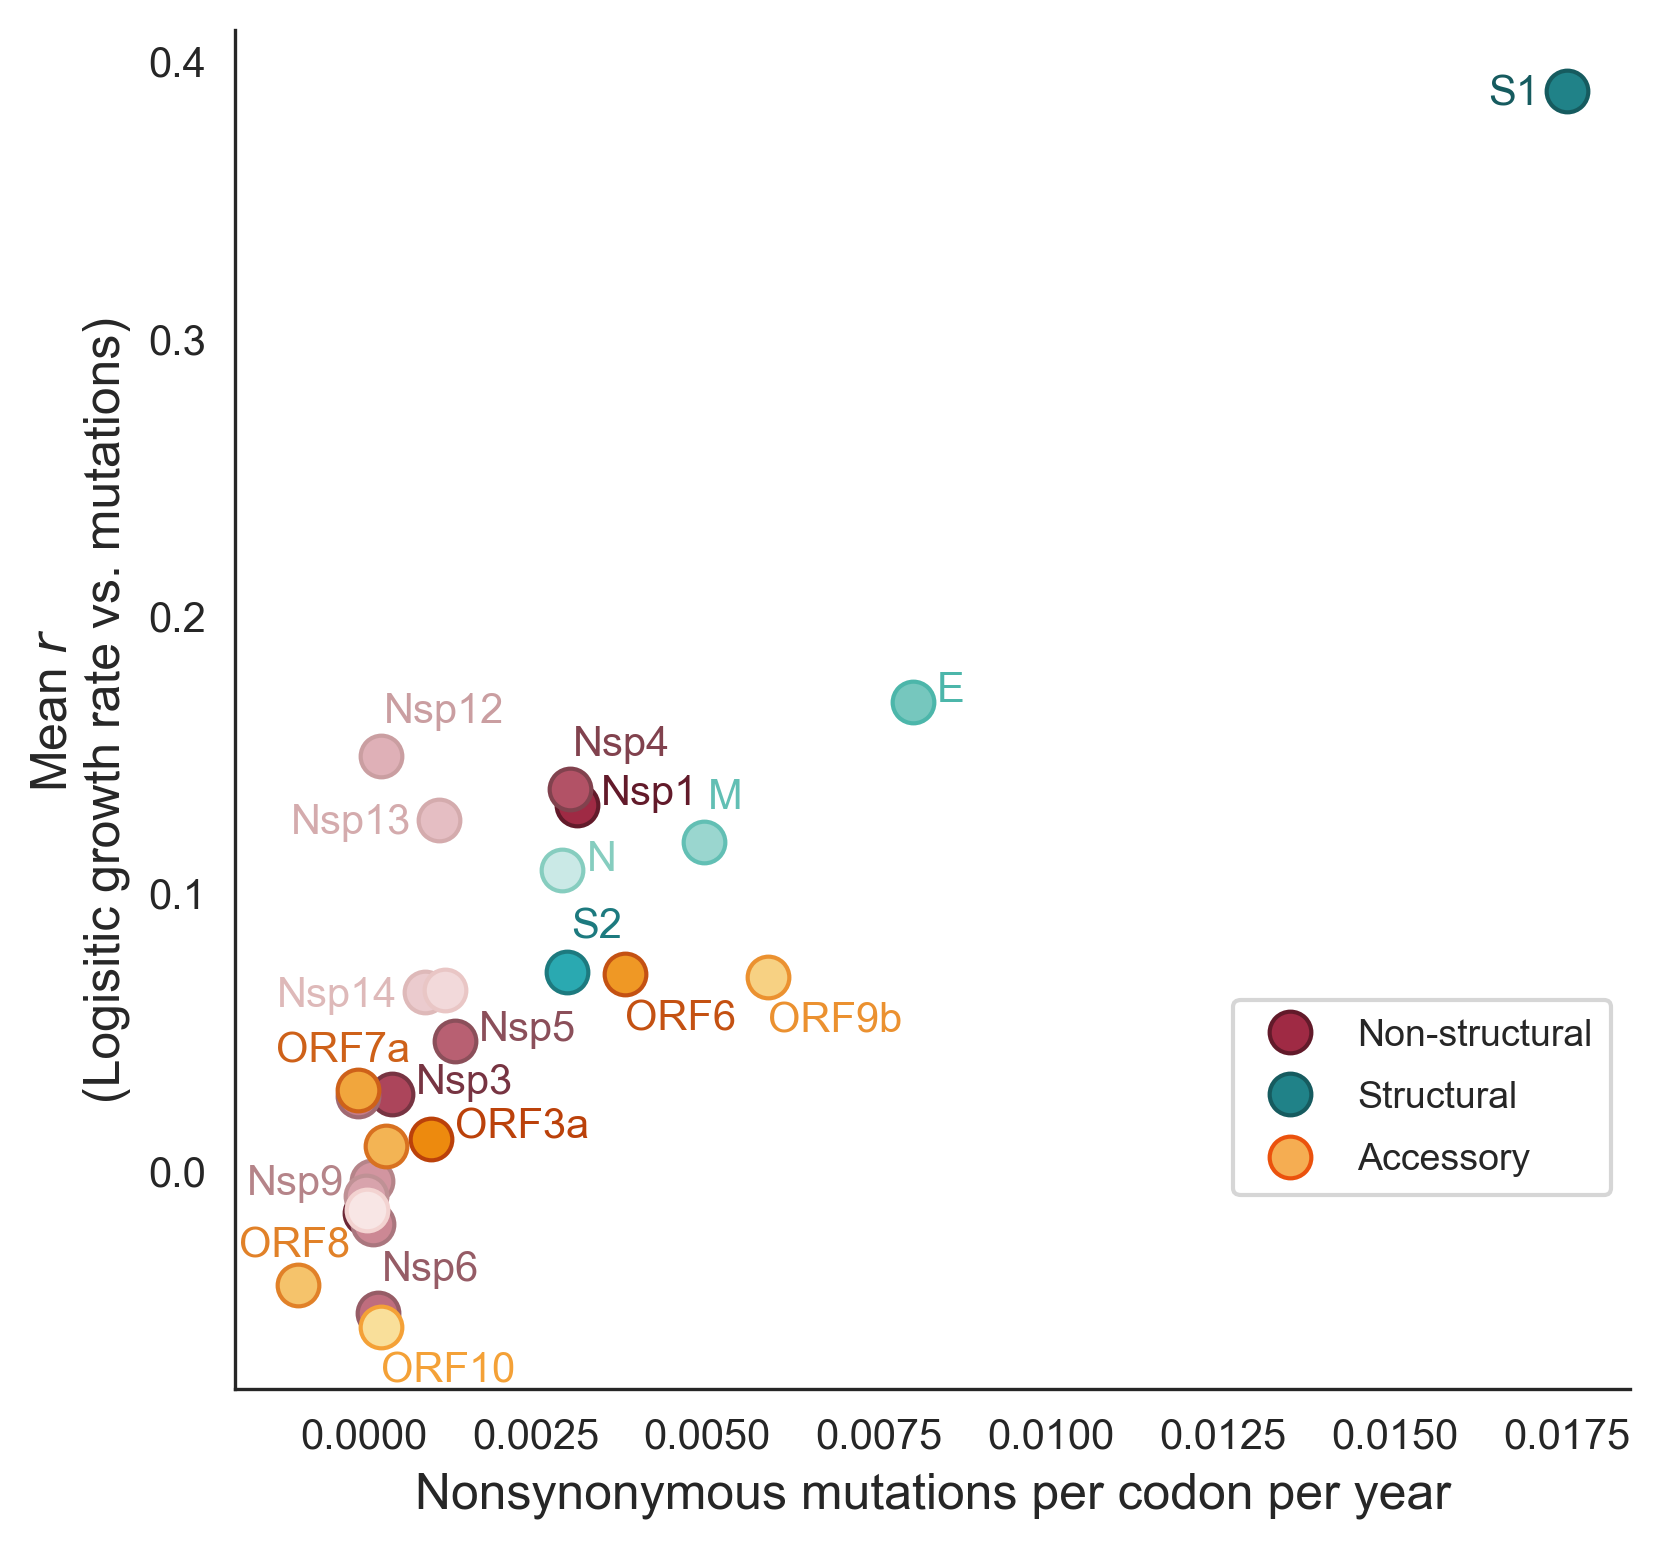

In [150]:
# plot nonsynonymous evo rate against the correlation between mutations and growth rate for each gene
# exclude S, because S1 and S2 are there

#plot text styling
sns.set_style("white")
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9

plt.rcParams['figure.dpi']= 300

# initiate axis
fig, ax = plt.subplots(figsize=(6,6))

# so that we can fit more text labels without things overlapping, manually decide where they go
text_up = ['M', 'S2', 'Nsp12', 'Nsp4', 'Nsp6']
text_middle = ['E', 'N', 'Nsp1', 'Nsp5', 'ORF3a', 'Nsp5', 'Nsp3']
text_down = ['ORF6', 'ORF9b', 'ORF10']
text_left = ['Nsp13', 'Nsp14', 'S1', 'Nsp9']
text_left_up = ['ORF8', 'ORF7a']

for g in all_genes:
    if g!= 'S':
        X = normalized_rate_by_gene[g]
        Y = float(mean_r[mean_r['gene']==g]['r_nonsyn'])
        ax.plot(X, Y, 'o', ms=10, color=cmap[g], markeredgecolor=edge_cmap[g], label=g)
#         ax.annotate(g, (X, Y-0.02), color=edge_cmap[g])
        if g in text_up:
            ax.annotate(g, (X+0.00005, Y+0.012), color=edge_cmap[g], ha='left')
        elif g in text_middle:
            ax.annotate(g, (X+0.00035, Y), color=edge_cmap[g], ha='left')
        elif g in text_down:
            ax.annotate(g, (X, Y-0.02), color=edge_cmap[g], ha='left')
        elif g in text_left:
            ax.annotate(g, (X-0.0004, Y-0.005), color=edge_cmap[g], ha='right')
        elif g in text_left_up:
            ax.annotate(g, (X+0.00075, Y+0.01), color=edge_cmap[g], ha='right')


ax.set_xlabel('Nonsynonymous mutations per codon per year')
ax.set_ylabel('Mean $\it{r}$\n(Logisitic growth rate vs. mutations)')

# add a legend for colors
legend_colors = {'Non-structural': '#9F2A44', 
                 'Structural': '#208288', 
                 'Accessory':'#F5AD52'}
legend_edgecolors = {'Non-structural': '#621a2a', 
                 'Structural': '#165b5f', 
                 'Accessory':'#eb520d'}
handles = []
leg_text = []
for k,v in legend_colors.items():
    handles.append(Line2D([], [], color='white', marker='o', 
                          markerfacecolor=v, markeredgecolor=legend_edgecolors[k], markersize=10))
    leg_text.append(k)

leg = ax.legend(handles, leg_text,
                  bbox_to_anchor=(1.0, 0.3), frameon=True, labelspacing = 0.75, borderpad=0.5)
        
sns.despine()

fig.savefig('r_vs_nonsyn_rate.png', dpi=300, bbox_inches='tight', transparent=False, facecolor='white')